# Libraries and Functions

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 42.8 MB/s 
     |████████████████████████████████| 16.7 MB 45.7 MB/s 


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from functools import partial
import pyproj
from pyproj import Transformer
from pyproj import CRS
from shapely.ops import transform

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
def gen_points_inside_polygon(polygon, miles=0.25):
    '''Takes a polygon and number of miles as input, creates a square grid around the polygon edges
    and iterates in default quarter mile steps exhaustively across the grid, returns list of all the points
    generated'''
    
    #convert miles to degrees latitude/longitude 
    lat_increment = miles * 0.0145
    lon_increment = miles * 0.02 #this is specifically for L.A. (varies based on lat)
    
    #get the four corners of a grid of max and min lat/long values 
    min_long, min_lat, max_long, max_lat = polygon.bounds
    
    #iterate over the grid one unit at a time, append lats and lons to lists:
    longs, lats = [], []
    
    #Latitudes: start one half unit away from min_lat:
    lat = min_lat + (lat_increment / 2)
    while lat < max_lat:
        lats.append(lat)
        lat += lat_increment
    lats.append(max_lat)
    
    #repeat for longitude; conversion is diff, 1 mile = 0.0145 degrees
    #start one half unit above the min_lat
    lon = min_long + (lon_increment / 2)
    while lon < max_long:
        longs.append(lon)
        #increase .02 degrees (longitude conversion for Los Angeles)
        lon += lon_increment
    longs.append(max_long)

    #iterate thru all latitude and longitude points, instantiate shapely Point objects
    #and append them to a list:
    points = []
    for i in range(len(longs)):
        for j in range(len(lats)):
            points.append(Point(longs[i], lats[j]))
            
    #iterate over the points and throw out ones outside the polygon:
    points_inside_polygon = []
    for i in range(len(points)):
        if polygon.contains(points[i]):
            points_inside_polygon.append(points[i])
            
    #if there are no points inside the polygon (very small polygon), add center as a point:    
    if len(points_inside_polygon) == 0:
        points_inside_polygon.append(polygon.centroid)
            
    #return the list of Shapely points which are bound inside the polygon        
    return points_inside_polygon

def make_circle(lon, lat, miles=1):
    km = miles * 1.60934
    proj_wgs84 = pyproj.CRS("WGS84")
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transformer.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buff = Point(0, 0).buffer(km * 1000)
    return Polygon(transform(project, buff).exterior.coords[:])

def get_num_groceries_in_circle(df, circle):
    min_long, min_lat, max_long, max_lat = circle.bounds
    df = df[(df.LATITUDE >= min_lat)&(df.LATITUDE <= max_lat)&(df.LONGITUDE>=min_long)&(df.LONGITUDE<=max_long)]
    num_groceries = 0
    for i in range(len(df)):
        if circle.contains(df.iloc[i]['LOCATION']):
            num_groceries += 1
    return num_groceries
        
def search_for_deserts(zip_df, markets_df):
    #initialize master dict which will store dicts for each zip code:
    return_dict = {}
    
    #iterate over each row in zip code dataframe:
    for i in range(len(zip_df)):
        zip_code = zip_df.iloc[i].zip_code
        nearby_grocery_counts = []
        desert_list = []
        
        #iterate over all the test_points for each zip code:
        for point in zip_df.iloc[i].test_points:
            lon, lat = point.x, point.y
            #make the circle around the test_point:
            circle = make_circle(lon, lat)
            #get the num of groceries within the circle and add to list for that zip code:
            num_nearby = get_num_groceries_in_circle(markets_df, circle)
            nearby_grocery_counts.append(num_nearby)
            #if there are no nearby groceries, add that point to list of food deserts:
            if num_nearby == 0:
                desert_list.append(point)
        
        #record the num of food deserts found for each zip code        
        num_food_deserts = len(desert_list)
        
        #store all the zip_code data as dict and add to master dict:
        
        #some zip codes are broken into mulitple polygons: this makes sure the data for these zip codes are aggregated:
        if zip_code in return_dict:
            return_dict[zip_code]['nearby_grocery_counts'] += nearby_grocery_counts
            return_dict[zip_code]['desert_list'] += desert_list
            return_dict[zip_code]['num_food_deserts'] += num_food_deserts
        else:
            return_dict[zip_code] = {'nearby_grocery_counts': nearby_grocery_counts, 
                               'desert_list': desert_list, 'num_food_deserts': num_food_deserts}
        
    #finished all iteration, now return the master dict of dictionaries for each zip code:
    return return_dict


def unpack_desert_search(desert_search_results):
    #initialize dict w/ empty lists
    unpacked = {'zip_code': [], 'nearby_grocery_counts': [], 'desert_list': [], 'num_food_deserts': []}
    #first get the zip code:
    for k, v in desert_search_results.items():
        unpacked['zip_code'].append(k)
        #now get the other key, value pairs for that zip code:
        for key, val in v.items():
            unpacked[key].append(val)
    #convert the dict into pandas df:        
    unpacked_df = pd.DataFrame(unpacked)        
    
    #initialize empty list of deserts:
    desert_list = []
    #iterate over the dataframe desert_list column and extract each desert and append to list:
    for i in range(len(unpacked_df)):
        deserts = unpacked_df.iloc[i].desert_list
        if len(deserts) > 0:
            for desert in deserts:
                desert_list.append(desert)
    
    #drop the desert_list column from the df:
    unpacked_df = unpacked_df.drop(columns=['desert_list'])
    
    #iterate over the grocery number counts and convert it to avg nearby groceries for each zip code:
    def get_avg(num_list):
        return round(sum(num_list)/len(num_list),1)
    
    unpacked_df.nearby_grocery_counts = unpacked_df.nearby_grocery_counts.apply(get_avg)
    unpacked_df = unpacked_df.rename(columns={'nearby_grocery_counts': 'avg_num_nearby_groceries'})
    
    #return the zip_code dataframe, and the list of all food deserts found in grid search:
    return unpacked_df, desert_list

# Load Data

In [ ]:
metros = ['Atlanta','DC','Baltimore','Phoenix','Minneapolis','Hartford'] 

In [ ]:
#big_df = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/RedFin TSV/neighborhood_market_tracker.tsv000', sep='\t',header=0)
for metro in metros:
  cleaned_df = big_df[big_df['parent_metro_region'].str.contains(metro)]
  cleaned_df.to_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/RedFin TSV/red_neighborhood_{}_data.csv'.format(metro))

In [ ]:
#needed to run once
#df = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/RedFin TSV/zip_code_market_tracker.tsv000', sep='\t', header=0)

metros =['Atlanta','Baltimore','DC','Hartford','Minneapolis','Phoenix']

In [ ]:
for metro in metros:
  cleaned_df = df[df['parent_metro_region'].str.contains(metro)]
  #cleaned_df.to_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/RedFin TSV/red_{}_data.csv'.format(metro))
  print(metro," has a shape of: ",cleaned_df.shape)

Atlanta  has a shape of:  (85480, 58)
DC  has a shape of:  (98089, 58)
Baltimore  has a shape of:  (56728, 58)
Phoenix  has a shape of:  (73098, 58)
Minneapolis  has a shape of:  (92305, 58)
Hartford  has a shape of:  (35873, 58)


In [ ]:
cleaned_df

In [ ]:
atlanta_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Atlanta/Atlanta_county_zips.csv')
baltimore_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Baltimore/Baltimore__county_zips.csv')
dc_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/DC/DC_county_zips.csv')
hartford_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Hartford/Hartford_county_zips.csv')
minneapolis_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Minneapolis/Minneapolis_county_zips.csv')
phoenix_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Phoenix/Phoenix_county_zips.csv')

In [ ]:
metros = ['Atlanta','DC','Baltimore','Phoenix','Minneapolis','Hartford']
for metro in metros:
  df = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/RedFin TSV/red_{}_data.csv'.format(metro))
  print(df.describe())

## Zipcode mapping

In [ ]:
# Use hartford first, smallest dataset
df = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/RedFin CSVs/redfin_Hartford_zip_data.csv')
#metro = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/RedFin CSVs/redfin_Hartford_zip_data.csv')
df.head()

,Unnamed: 0,period_begin,period_end,zip,state,property_type,property_type_id,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_list_price_mom,median_list_price_yoy,median_ppsf,median_ppsf_mom,median_ppsf_yoy,median_list_ppsf,median_list_ppsf_mom,median_list_ppsf_yoy,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,avg_sale_to_list_mom,avg_sale_to_list_yoy,sold_above_list,sold_above_list_mom,sold_above_list_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,year
0,0,12/1/2015,2/29/2016,6409,Connecticut,All Residential,-1,196000.0,-0.185031,0.960000,284500.0,0.000000,NaN,259.259259,0.163496,1.556296,141.121032,0.000000,NaN,1,-0.500000,0.000000,NaN,NaN,NaN,1.0,0.000000,NaN,5.0,0.000000,1.500000,420.0,200.5,92.0,0.899083,-0.042008,-0.100917,0.000000,0.000000,0.000000,NaN,NaN,NaN,2015
1,1,7/1/2015,9/30/2015,6118,Connecticut,Single Family Residential,6,129900.0,-0.037778,-0.094774,149450.0,-0.003002,0.067500,105.520394,-0.014370,-0.004064,114.008581,0.001663,0.063092,92,0.057471,0.045455,25.0,0.000000,0.190476,122.0,-0.134752,0.051724,168.0,-0.061453,-0.034483,74.0,9.0,-23.0,0.956956,-0.015522,-0.012528,0.206522,-0.046352,0.036067,0.280000,0.040000,0.232381,2015
2,2,3/1/2012,5/31/2012,6107,Connecticut,Single Family Residential,6,335000.0,0.046875,-0.014706,379900.0,-0.000132,0.120649,179.101835,0.072504,-0.010057,188.254632,0.019668,0.028252,70,0.372549,0.296296,25.0,0.785714,1.083333,107.0,0.091837,-0.122951,118.0,-0.016667,-0.218543,80.0,-5.0,-31.0,0.973509,0.006021,0.009849,0.200000,0.121569,0.107407,0.080000,0.080000,0.080000,2012
3,3,10/1/2015,12/31/2015,6001,Connecticut,Condo/Co-op,3,172000.0,-0.187530,-0.297959,208000.0,-0.032558,0.007752,132.272727,-0.030673,0.022355,137.561274,0.038860,0.024686,23,-0.178571,-0.115385,3.0,-0.571429,-0.400000,19.0,-0.296296,-0.136364,35.0,0.000000,0.093750,95.0,18.0,-52.5,0.949634,-0.006307,-0.009739,0.000000,-0.035714,-0.076923,0.333333,0.190476,0.333333,2015
4,4,6/1/2014,8/31/2014,6034,Connecticut,Condo/Co-op,3,91350.0,0.000000,-0.081910,110000.0,0.102757,0.024209,99.238461,0.000000,-0.068823,124.377593,0.151361,0.065050,2,0.000000,0.000000,NaN,NaN,NaN,5.0,1.500000,1.500000,4.0,NaN,1.000000,39.0,0.0,-128.0,0.922595,0.000000,0.016801,0.000000,0.000000,0.000000,NaN,NaN,NaN,2014


In [ ]:
#Make all of our polygons here

polygon_file = '/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/zip_shape/tl_2021_us_zcta520.shp'
polygons = gpd.read_file(polygon_file)
zip_df = polygons[['ZCTA5CE20', 'geometry']].rename(columns={'ZCTA5CE20':'zip_code'})
zip_df['zip_code'] = zip_df['zip_code'].astype(int)

metro_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Hartford/Hartford_county_zips.csv')

"""
#Not sure I need this method
metro_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Hartford/Hartford_county_zips.csv')
metro_zips['zip'] = metro_zips['zip'].astype(str)
"""

"\n#Not sure I need this method\nmetro_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Hartford/Hartford_county_zips.csv')\nmetro_zips['zip'] = metro_zips['zip'].astype(str)\n"

In [ ]:
metro_zips.head()

In [ ]:
median_by_zip = df.groupby(['year','zip'])['median_sale_price'].mean()
median_by_zip#.unstack()

In [ ]:
median_2021 = df.query('year == 2021').groupby(['zip'])['median_sale_price'].mean().astype(int).reset_index()
median_2021

In [ ]:
median_2021.describe()

In [ ]:
metro_zip_list = metro_zips['zip'].to_list()
metro_zip_df = zip_df[zip_df['zip_code'].isin(metro_zip_list)]

median_density = metro_zip_df.merge(median_2021, left_on='zip_code',right_on='zip',how='outer')

median_density


In [ ]:
  fig, ax = plt.subplots(figsize = (25,25))
  cmap = 'Spectral_r'
  #Color bar is created below
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=500000))
  # Empty array for the data range
  sm._A = []
  # Add the colorbar to the figure
  cbar = fig.colorbar(sm, fraction=.04)

  ax.set_facecolor('#f0f0f5')
  plt.title('Housing Density',fontsize=20)
  plt.xlabel('Longitude', fontsize=15)
  plt.ylabel('Latitude',fontsize=15)
  plt.grid(linewidth=0.2)
  #ax.set_ylim([38,40])
  #ax.set_xlim([-79,-76])
  ax_zip = median_density.plot(column='median_sale_price', ax=ax, cmap=cmap, vmin=0, vmax =555000)

In [ ]:
df.describe()

,Unnamed: 0,zip,property_type_id,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_list_price_mom,median_list_price_yoy,median_ppsf,median_ppsf_mom,median_ppsf_yoy,median_list_ppsf,median_list_ppsf_mom,median_list_ppsf_yoy,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,avg_sale_to_list_mom,avg_sale_to_list_yoy,sold_above_list,sold_above_list_mom,sold_above_list_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,year
count,35873.00000,35873.000000,35873.000000,3.587300e+04,34662.000000,32908.000000,3.392400e+04,32725.000000,31572.000000,35865.000000,34655.000000,32905.000000,33920.000000,32722.000000,31572.000000,35873.00000,34662.000000,32908.000000,27324.000000,23787.000000,23155.000000,33930.000000,32729.000000,31576.000000,34102.000000,33043.000000,31882.000000,35838.000000,34618.000000,32870.000000,35862.000000,34650.000000,32899.000000,35873.000000,34662.000000,32908.000000,27324.000000,23787.000000,23155.000000,35873.000000
mean,17936.00000,6172.630669,2.806595,2.307076e+05,0.026560,0.096566,2.480770e+05,0.040862,0.056523,126.909782,0.015366,0.061428,134.884914,0.087516,0.037466,26.18270,0.060894,0.217987,7.901808,0.261790,0.435854,35.746508,0.048417,0.140040,44.998534,0.016234,-0.009867,102.979672,-1.133543,-11.524566,0.968770,0.000551,0.006402,0.212403,0.003339,0.043531,0.183715,0.003975,0.027579,2016.563237
std,10355.78744,163.228419,2.876491,1.025746e+05,0.916446,1.886617,1.270167e+05,2.382422,0.612663,39.767010,0.622209,0.987926,39.946814,10.497020,0.629217,33.25181,0.395741,0.751896,9.497447,0.988742,1.123761,42.784909,0.425576,0.743436,52.850308,0.289733,0.547655,88.572806,54.306053,93.604684,0.044566,0.025263,0.047804,0.225140,0.122448,0.222340,0.247593,0.287171,0.291872,2.871344
min,0.00000,6001.000000,-1.000000,9.000000e+02,-0.991701,-0.996190,1.000000e+03,-0.994442,-0.989592,0.069950,-0.987090,-0.992809,0.069950,-0.991814,-0.989592,1.00000,-0.875000,-0.928571,1.000000,-0.933333,-0.923077,1.000000,-0.952381,-0.923077,1.000000,-0.900000,-0.933333,1.000000,-1753.000000,-2221.000000,0.506329,-0.605879,-0.700631,0.000000,-1.000000,-1.000000,0.000000,-1.500000,-1.166667,2012.000000
25%,8968.00000,6053.000000,-1.000000,1.599500e+05,-0.041777,-0.084210,1.699000e+05,-0.043564,-0.074919,106.704617,-0.028711,-0.062835,114.804716,-0.027435,-0.053088,4.00000,-0.130435,-0.155172,2.000000,-0.333333,-0.214286,7.000000,-0.160000,-0.187500,8.000000,-0.111111,-0.278659,58.125000,-9.000000,-34.000000,0.953394,-0.005990,-0.009773,0.000000,-0.026961,-0.033333,0.000000,-0.099265,-0.053571,2014.000000
50%,17936.00000,6096.000000,3.000000,2.200000e+05,0.000000,0.034716,2.349000e+05,0.000000,0.022443,129.262926,0.000000,0.021315,136.147444,0.000000,0.012208,14.00000,0.000000,0.037037,4.000000,0.000000,0.071429,21.000000,0.000000,0.000000,28.000000,0.000000,-0.084953,83.500000,0.000000,-8.500000,0.969758,0.000000,0.005514,0.166667,0.000000,0.010033,0.083333,0.000000,0.000000,2017.000000
75%,26904.00000,6268.000000,6.000000,2.860000e+05,0.049723,0.165830,2.999990e+05,0.047619,0.132125,147.814742,0.034968,0.122449,154.445024,0.032794,0.092034,35.00000,0.164179,0.375000,10.000000,0.500000,0.750000,47.000000,0.173913,0.263158,61.000000,0.092593,0.111111,122.000000,8.000000,14.000000,0.986739,0.007132,0.022262,0.303371,0.033858,0.125000,0.300000,0.095238,0.142857,2019.000000
max,35872.00000,6498.000000,13.000000,1.700000e+06,117.214286,215.666667,5.900000e+06,256.727273,95.076923,487.793451,107.133998,135.016260,541.666667,1838.058625,106.042224,359.00000,6.000000,15.000000,113.000000,11.000000,16.000000,403.000000,27.000000,31.000000,529.000000,6.000000,11.000000,2418.000000,1680.000000,1575.000000,1.746032,0.704366,0.777070,1.000000,1.000000,1.000000,1.500000,1.500000,1.500000,2021.00000

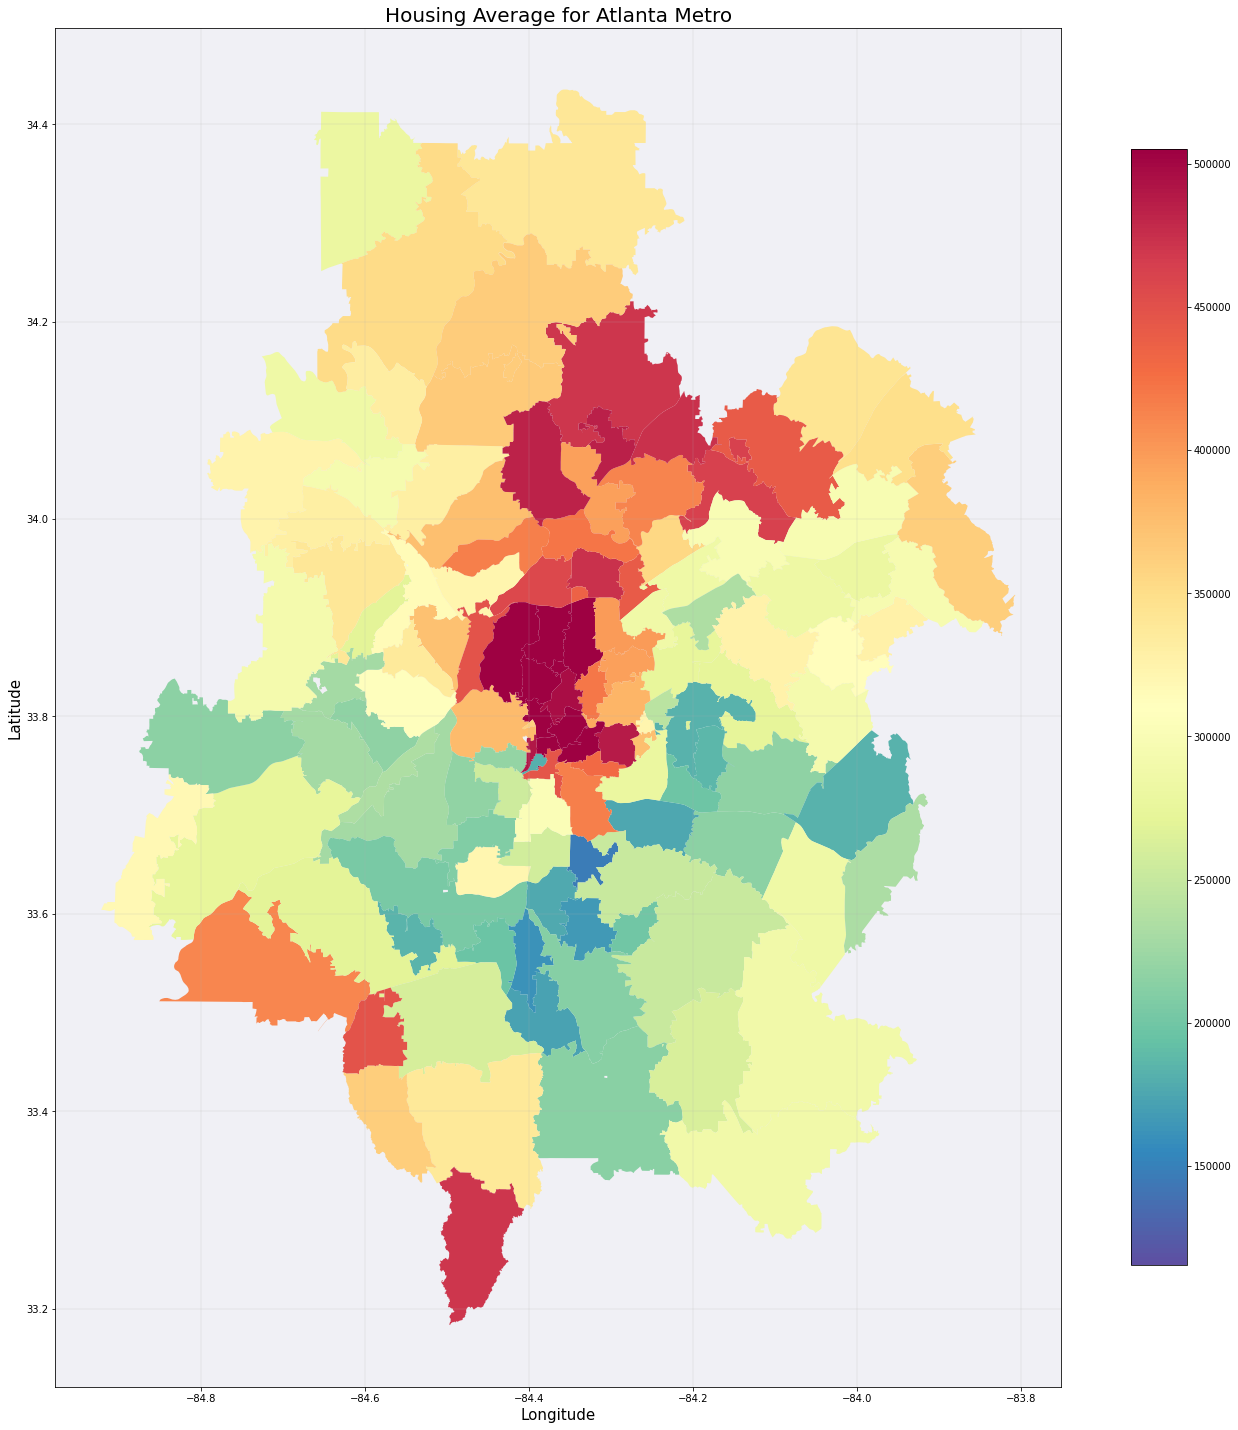

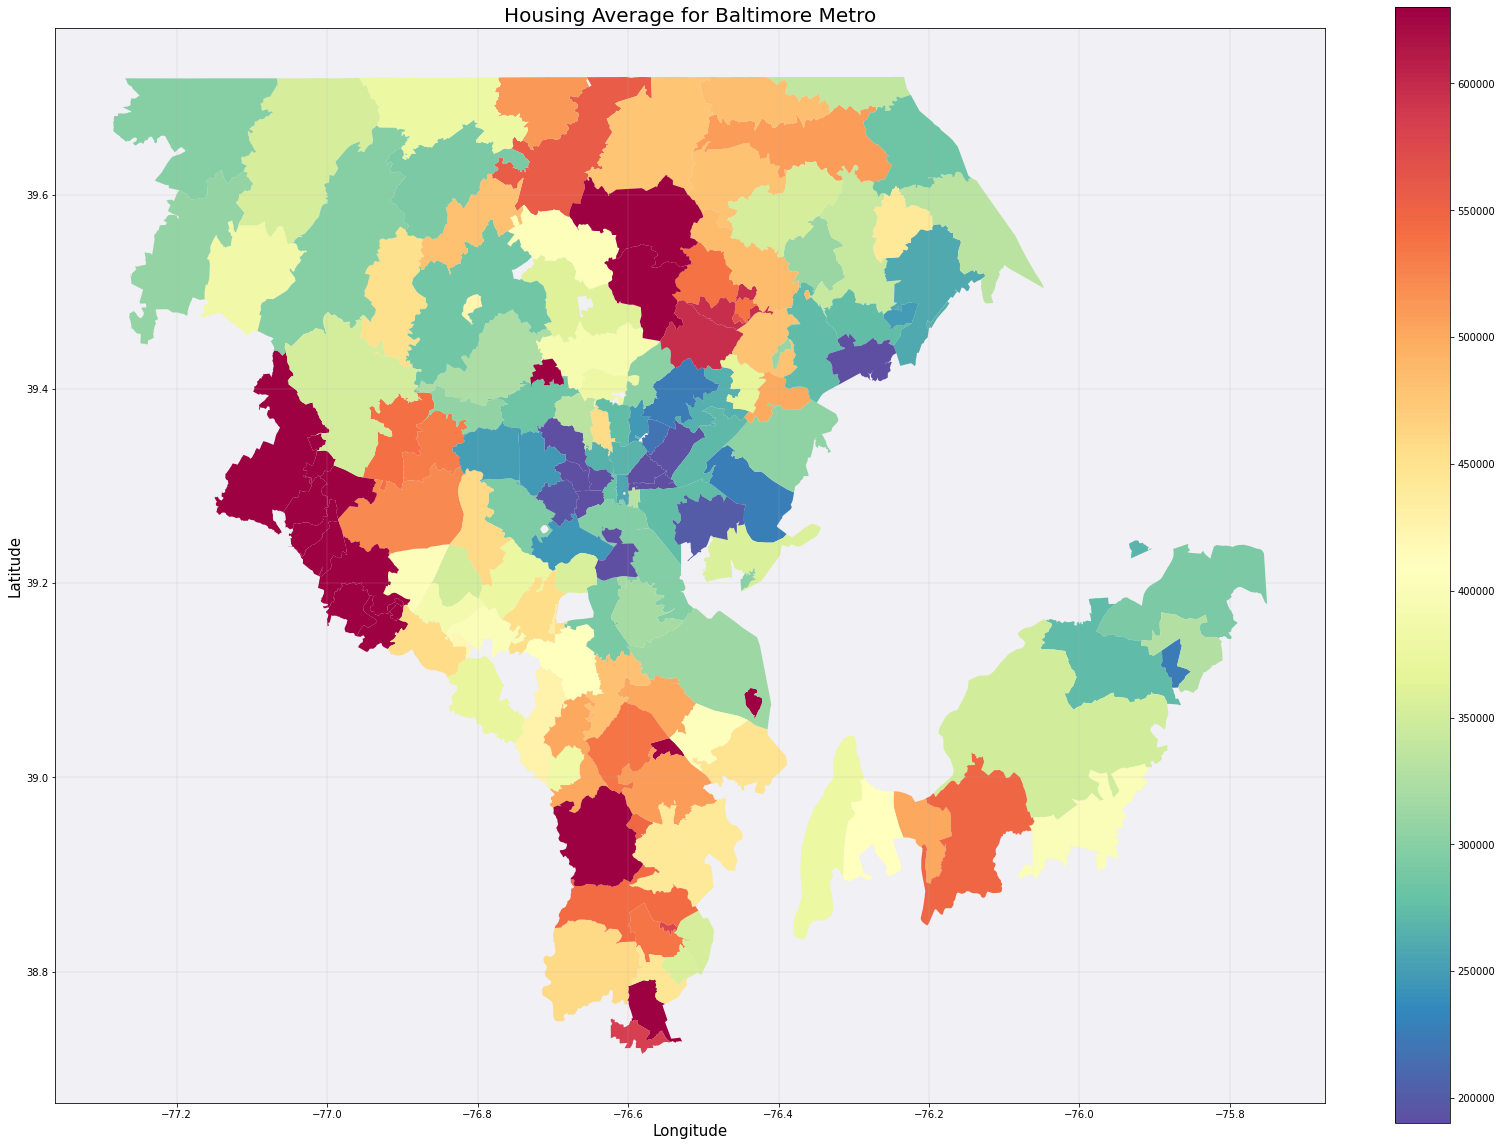

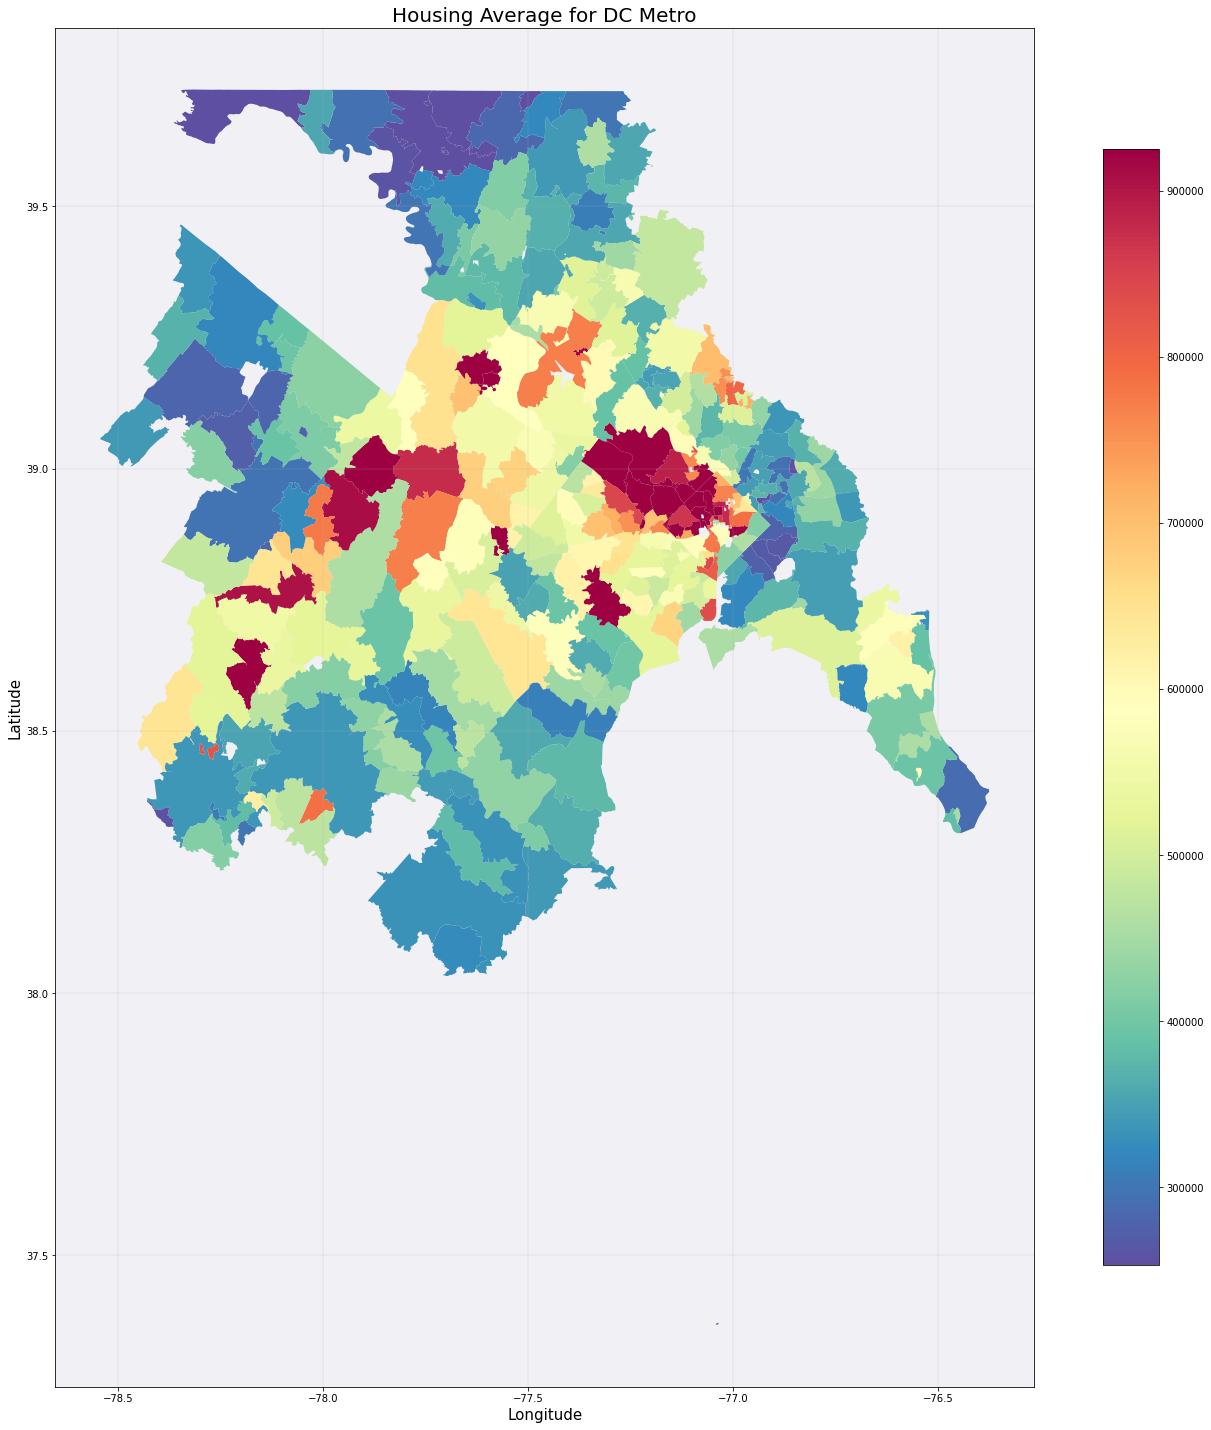

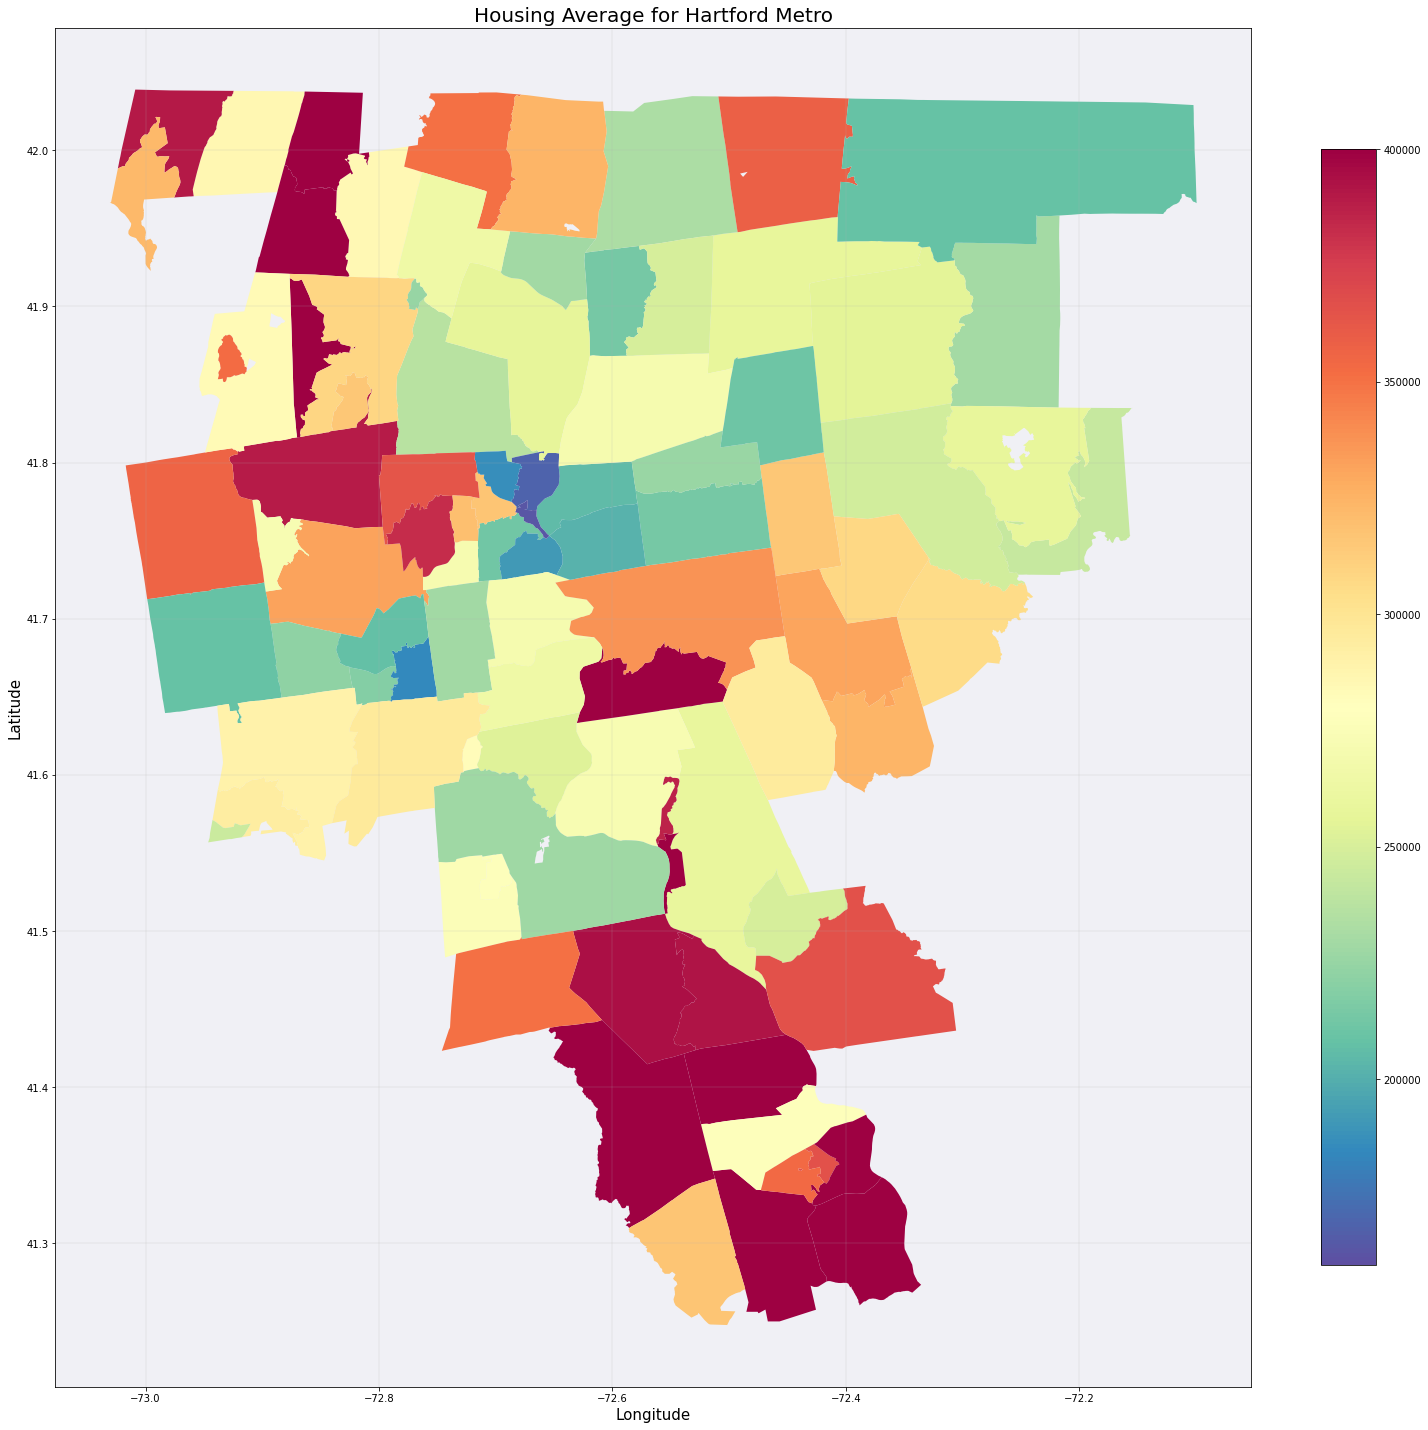

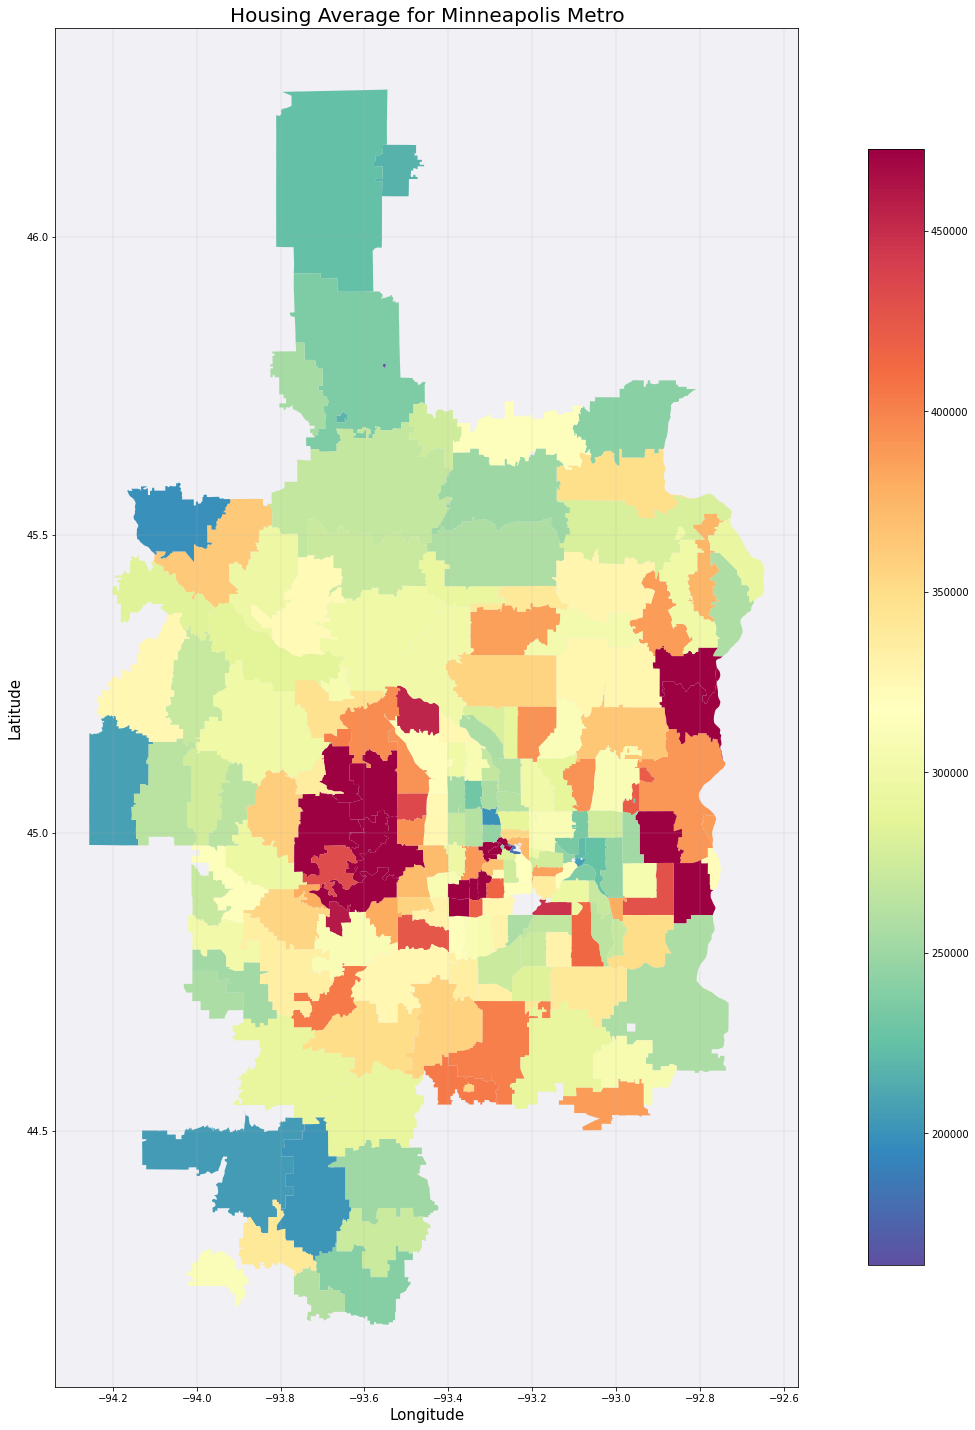

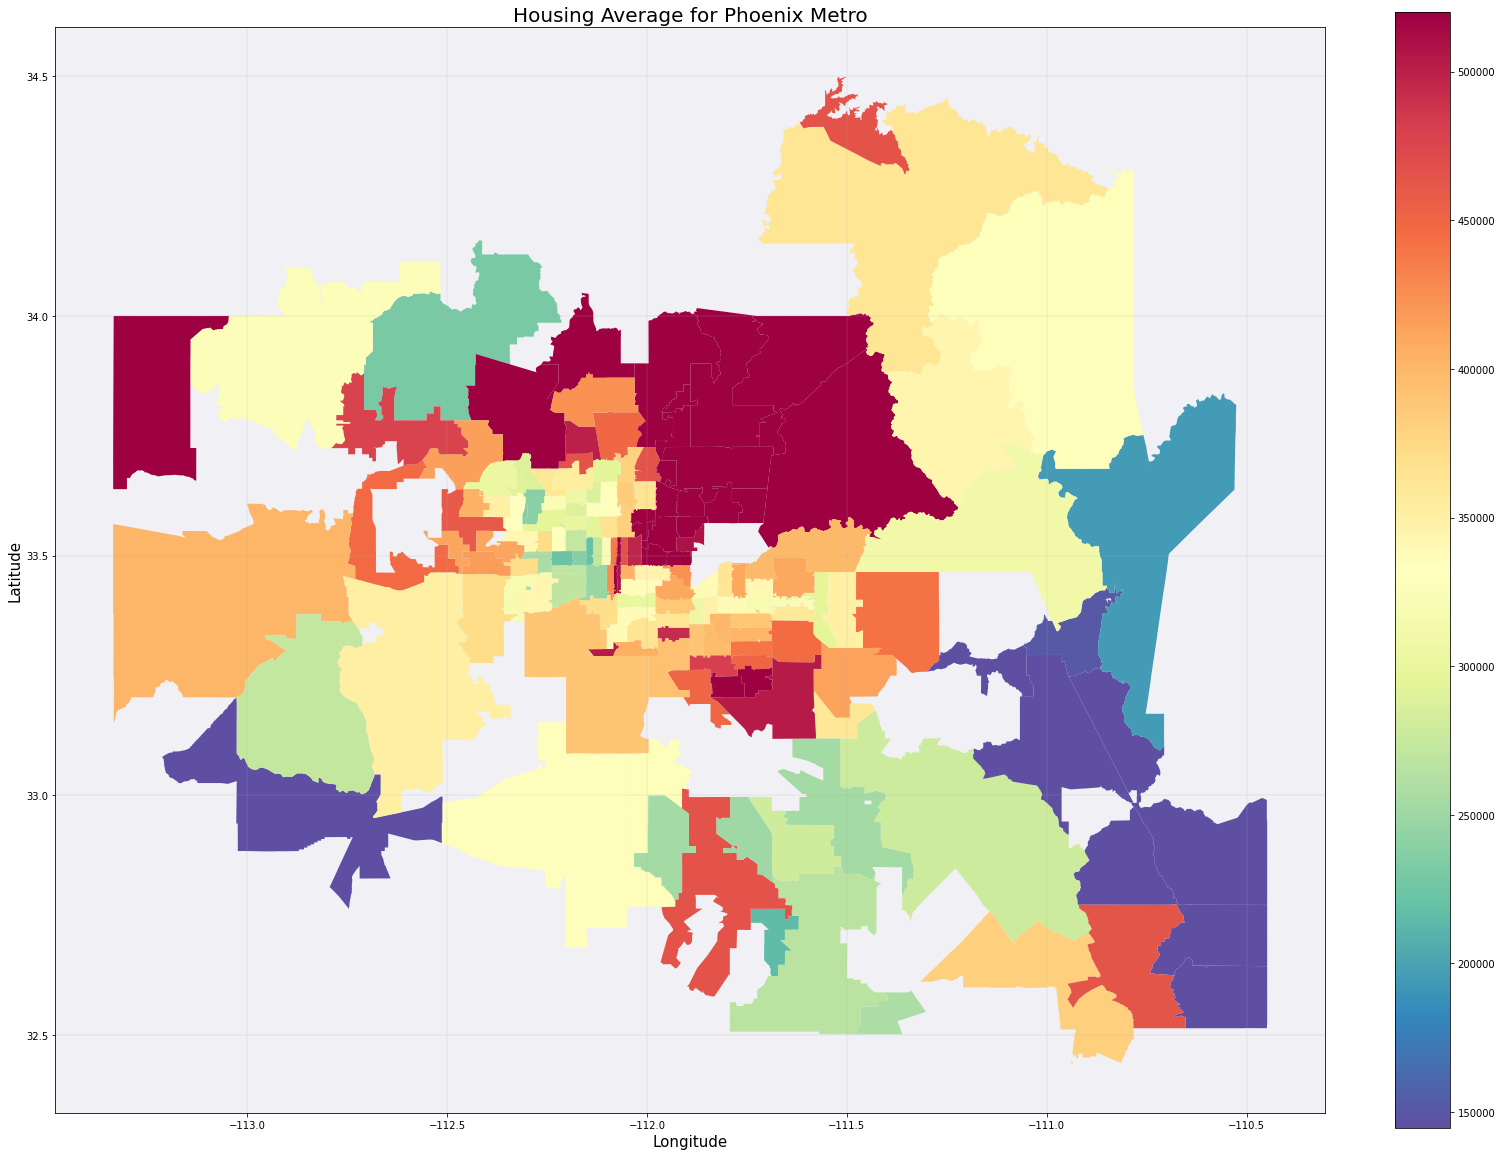

In [ ]:
for metro in metros:
  metro_zips = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/{}/{}_county_zips.csv'.format(metro,metro))
  df = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/RedFin CSVs/redfin_{}_zip_data.csv'.format(metro))
  median_2021 = df.query('year == 2021').groupby(['zip'])['median_sale_price'].mean().astype(int).reset_index()

  vmax = df['median_sale_price'].quantile(.95)
  vmin = df['median_sale_price'].quantile(.25)#min()*2

  metro_zip_list = metro_zips['zip'].to_list()
  metro_zip_df = zip_df[zip_df['zip_code'].isin(metro_zip_list)]

  median_density = metro_zip_df.merge(median_2021, left_on='zip_code',right_on='zip',how='outer')

  fig, ax = plt.subplots(figsize = (25,25))
  cmap = 'Spectral_r'
  #Color bar is created below
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
  # Empty array for the data range
  sm._A = []
  # Add the colorbar to the figure
  cbar = fig.colorbar(sm, fraction=.04)

  ax.set_facecolor('#f0f0f5')
  plt.title('Housing Average for {} Metro'.format(metro),fontsize=20)
  plt.xlabel('Longitude', fontsize=15)
  plt.ylabel('Latitude',fontsize=15)
  plt.grid(linewidth=0.2)
  #ax.set_ylim([38,40])
  #ax.set_xlim([-79,-76])
  ax_zip = median_density.plot(column='median_sale_price', ax=ax, cmap=cmap, vmin=vmin, vmax =vmax)
  plt.savefig('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/Graphs/RedFin Graphs/Median Sales/{}_map_median.png'.format(metro))